<a href="https://colab.research.google.com/github/Hetvi48/AeroCare/blob/main/All_model_3_aircraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [ ]:
# --- 1. Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import warnings
# warnings.filterwarnings('ignore')

# --- 2. Load and prepare NASA dataset ---
def load_cmapss_train(path_train):
    df = pd.read_csv(path_train, sep='\s+', header=None, engine='python')
    df = df.iloc[:, :26]  # adjust if needed
    cols = ["unit", "cycle"] + [f"op{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]
    df.columns = cols
    return df

def make_rul(df):
    df = df.copy()
    max_cycle = df.groupby('unit')['cycle'].transform('max')
    df['RUL'] = max_cycle - df['cycle']
    return df

train_path = "drive/MyDrive/archive/CMaps/train_FD003.txt"  # update path if needed
df = load_cmapss_train(train_path)
df = make_rul(df)

X = df.drop(columns=['unit', 'RUL'])
y = df['RUL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Evaluation helper ---
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) # Removed squared=False
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
    return mae, rmse, r2

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3614403416.py:13: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(path_train, sep='\s+', header=None, engine='python')


In [ ]:
df.size

667440

In [ ]:
df.shape

(24720, 27)

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

print("➡ Linear Regression Results:")
evaluate_model(pipe, X_train, y_train, X_test, y_test)

➡ Linear Regression Results:
MAE: 45.423 | RMSE: 3723.994 | R²: 0.620


(45.423147131822866, 3723.993742572261, 0.6200245181435053)

# Ridge

In [ ]:
from sklearn.linear_model import Ridge

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

param_grid = {'model__alpha': np.logspace(-3, 3, 20)}

search = RandomizedSearchCV(pipe, param_grid, cv=5, n_iter=10,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best Ridge params:", search.best_params_)
best_ridge = search.best_estimator_
evaluate_model(best_ridge, X_train, y_train, X_test, y_test)


Best Ridge params: {'model__alpha': np.float64(483.2930238571752)}
MAE: 45.352 | RMSE: 3722.343 | R²: 0.620


(45.35201379146579, 3722.343017102797, 0.6201929489328759)

# Lasso

In [ ]:
from sklearn.linear_model import Lasso

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(max_iter=5000))
])

param_grid = {'model__alpha': np.logspace(-4, 1, 20)}

search = RandomizedSearchCV(pipe, param_grid, cv=5, n_iter=10,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best Lasso params:", search.best_params_)
best_lasso = search.best_estimator_
evaluate_model(best_lasso, X_train, y_train, X_test, y_test)


Best Lasso params: {'model__alpha': np.float64(1.623776739188721)}
MAE: 45.314 | RMSE: 3736.192 | R²: 0.619


(45.31429385345145, 3736.192007970761, 0.6187798754042813)

# Elastic net

In [ ]:
from sklearn.linear_model import ElasticNet

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet(max_iter=5000))
])

param_grid = {
    'model__alpha': np.logspace(-3, 1, 10),
    'model__l1_ratio': np.linspace(0, 1, 10)
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=20, cv=5,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best ElasticNet params:", search.best_params_)
best_en = search.best_estimator_
evaluate_model(best_en, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.906e+07, tolerance: 1.554e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.853e+07, tolerance: 1.534e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best ElasticNet params: {'model__l1_ratio': np.float64(0.3333333333333333), 'model__alpha': np.float64(0.1668100537200059)}
MAE: 45.258 | RMSE: 3734.896 | R²: 0.619


(45.258207981294284, 3734.895568218712, 0.6189121568616455)

# kNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance']
}

search = RandomizedSearchCV(pipe, param_grid, cv=5, n_iter=6,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best KNN params:", search.best_params_)
best_knn = search.best_estimator_
evaluate_model(best_knn, X_train, y_train, X_test, y_test)


Best KNN params: {'model__weights': 'uniform', 'model__n_neighbors': 11}
MAE: 36.118 | RMSE: 2906.469 | R²: 0.703


(36.118251691674025, 2906.4688795501347, 0.7034401802605771)

# SVR

In [ ]:
from sklearn.svm import SVR

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

param_grid = {
    'model__C': [0.1, 1, 10, 50],
    'model__epsilon': [0.01, 0.1, 0.5],
    'model__kernel': ['rbf', 'poly']
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best SVR params:", search.best_params_)
best_svr = search.best_estimator_
evaluate_model(best_svr, X_train, y_train, X_test, y_test)


Best SVR params: {'model__kernel': 'rbf', 'model__epsilon': 0.01, 'model__C': 50}
MAE: 33.239 | RMSE: 2823.308 | R²: 0.712


(33.23877589442997, 2823.3078220992743, 0.7119254691898651)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=42))
])

param_grid = {
    'model__max_depth': [5, 10, 15, 20, None],
    'model__min_samples_leaf': [1, 3, 5, 10]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=5,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best DecisionTree params:", search.best_params_)
best_tree = search.best_estimator_
evaluate_model(best_tree, X_train, y_train, X_test, y_test)


Best DecisionTree params: {'model__min_samples_leaf': 3, 'model__max_depth': 10}
MAE: 35.839 | RMSE: 3022.170 | R²: 0.692


(35.838728628289026, 3022.169589023598, 0.6916347273322511)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [100, 200, 400],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

print("Best RandomForest params:", search.best_params_)
best_rf = search.best_estimator_
evaluate_model(best_rf, X_train, y_train, X_test, y_test)


Best RandomForest params: {'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__max_depth': 20}
MAE: 32.306 | RMSE: 2346.538 | R²: 0.761


(32.30616414609841, 2346.537613883662, 0.7605724332087724)

# Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best GBR params:", search.best_params_)
best_gbr = search.best_estimator_
evaluate_model(best_gbr, X_train, y_train, X_test, y_test)


Best GBR params: {'model__n_estimators': 400, 'model__max_depth': 7, 'model__learning_rate': 0.01}
MAE: 33.010 | RMSE: 2410.459 | R²: 0.754


(33.01018030528657, 2410.4586722260965, 0.7540502861206124)

# XGBoost

In [ ]:
import xgboost as xgb

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [4, 6, 10],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best XGBoost params:", search.best_params_)
best_xgb = search.best_estimator_
evaluate_model(best_xgb, X_train, y_train, X_test, y_test)


Best XGBoost params: {'model__subsample': 0.8, 'model__n_estimators': 400, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}
MAE: 32.342 | RMSE: 2342.778 | R²: 0.761


(32.34151077270508, 2342.778076171875, 0.7609560489654541)

# light gbm

In [ ]:
import lightgbm as lgb

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50, 100],
    'model__max_depth': [-1, 10, 20]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best LightGBM params:", search.best_params_)
best_lgbm = search.best_estimator_
evaluate_model(best_lgbm, X_train, y_train, X_test, y_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.587075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 137.327215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 19
[LightGBM] [Info] Start training from score 138.026699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3364
[LightGBM] [Info] Number of data points in the train set: 19776, number of used features: 19
[LightGBM] [Info] Start training from score 137.646996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(32.5596763450339, 2422.1382207158144, 0.7528585703519974)

# MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(max_iter=500, random_state=42))
])

param_grid = {
    'model__hidden_layer_sizes': [(64,), (128,64), (128,64,32)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best MLP params:", search.best_params_)
best_mlp = search.best_estimator_
evaluate_model(best_mlp, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best MLP params: {'model__learning_rate_init': 0.001, 'model__hidden_layer_sizes': (128, 64), 'model__alpha': 0.001}
MAE: 33.510 | RMSE: 2420.975 | R²: 0.753


(33.510447877870824, 2420.975122113977, 0.7529772464245772)

# Results

In [ ]:
results = {
    "Model": ["LinearRegression", "Ridge", "Lasso", "ElasticNet", "KNeighborsRegressor", "SVR", "DecisionTreeRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "xgb", "lgb", "MLPRegressor"],
    "MAE": [45.423147131822866, 45.35201379146579, 45.31429385345145, 45.258207981294284, 36.118251691674025, 33.23877589442997, 35.838728628289026, 32.30616414609841, 33.01018030528657, 32.34151077270508, 32.5596763450339, 33.510447877870824],
    "RMSE": [3723.993742572261, 3722.343017102797, 3736.192007970761, 3734.895568218712, 2906.4688795501347, 2823.3078220992743, 3022.169589023598, 2346.537613883662, 2410.4586722260965, 2342.778076171875, 2422.1382207158144, 2420.975122113977],
    "R2": [0.6200245181435053, 0.6201929489328759, 0.6187798754042813, 0.6189121568616455, 0.7034401802605771, 0.7119254691898651, 0.6916347273322511, 0.7605724332087724, 0.7540502861206124, 0.7609560489654541, 0.7528585703519974, 0.7529772464245772]
}

results_df = pd.DataFrame(results)
print(results_df)


                        Model        MAE         RMSE        R2
0            LinearRegression  45.423147  3723.993743  0.620025
1                       Ridge  45.352014  3722.343017  0.620193
2                       Lasso  45.314294  3736.192008  0.618780
3                  ElasticNet  45.258208  3734.895568  0.618912
4         KNeighborsRegressor  36.118252  2906.468880  0.703440
5                         SVR  33.238776  2823.307822  0.711925
6       DecisionTreeRegressor  35.838729  3022.169589  0.691635
7       RandomForestRegressor  32.306164  2346.537614  0.760572
8   GradientBoostingRegressor  33.010180  2410.458672  0.754050
9                         xgb  32.341511  2342.778076  0.760956
10                        lgb  32.559676  2422.138221  0.752859
11               MLPRegressor  33.510448  2420.975122  0.752977


                        Model        MAE         RMSE        R2
7       RandomForestRegressor  32.306164  2346.537614  0.760572
9                         xgb  32.341511  2342.778076  0.760956
10                        lgb  32.559676  2422.138221  0.752859
8   GradientBoostingRegressor  33.010180  2410.458672  0.754050
5                         SVR  33.238776  2823.307822  0.711925
11               MLPRegressor  33.510448  2420.975122  0.752977
6       DecisionTreeRegressor  35.838729  3022.169589  0.691635
4         KNeighborsRegressor  36.118252  2906.468880  0.703440
3                  ElasticNet  45.258208  3734.895568  0.618912
2                       Lasso  45.314294  3736.192008  0.618780
1                       Ridge  45.352014  3722.343017  0.620193
0            LinearRegression  45.423147  3723.993743  0.620025


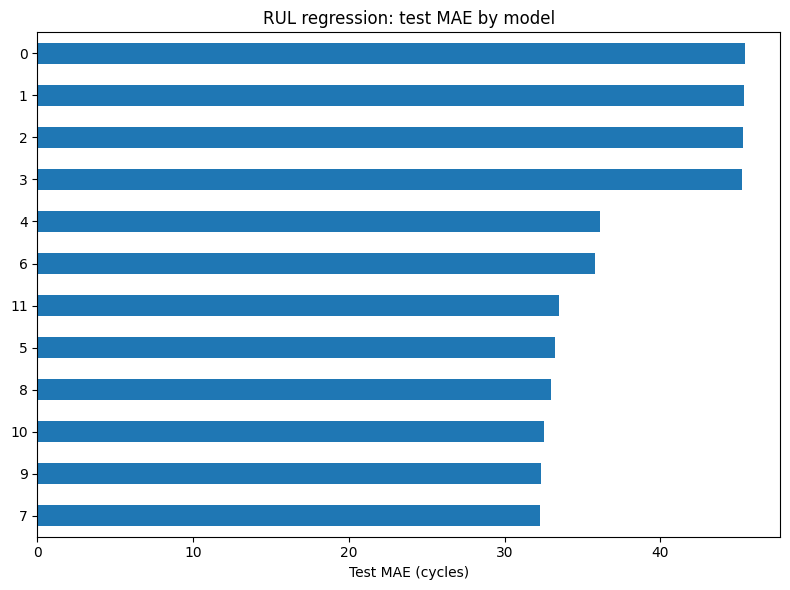

In [ ]:
import matplotlib.pyplot as plt

res = results_df.copy()
res = res.sort_values('MAE')
print(res[['Model','MAE','RMSE','R2']])
res['MAE'].plot.barh(figsize=(8,6))
plt.xlabel("Test MAE (cycles)")
plt.title("RUL regression: test MAE by model")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb


# Hyper-parameter Tuning for best models

In [ ]:
best_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(
        n_estimators=400,
        max_depth=20,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    ))
])
best_rf.fit(X_train, y_train)

y_pred_rf = best_rf.predict(X_test)


In [ ]:
best_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(
        subsample=0.8,
        n_estimators=400,
        max_depth=10,
        learning_rate=0.01,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])
best_xgb.fit(X_train, y_train)

y_pred_xgb = best_xgb.predict(X_test)


In [ ]:
best_lgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMRegressor(
        num_leaves=100,
        n_estimators=200,
        max_depth=20,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    ))
])
best_lgb.fit(X_train, y_train)

y_pred_lgb = best_lgb.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3364
[LightGBM] [Info] Number of data points in the train set: 19776, number of used features: 19
[LightGBM] [Info] Start training from score 137.646996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
evaluate_model(best_rf, X_train, y_train, X_test, y_test)
evaluate_model(best_xgb, X_train, y_train, X_test, y_test)
evaluate_model(best_lgb, X_train, y_train, X_test, y_test)


MAE: 32.306 | RMSE: 2346.538 | R²: 0.761
MAE: 32.342 | RMSE: 2342.778 | R²: 0.761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3364
[LightGBM] [Info] Number of data points in the train set: 19776, number of used features: 19
[LightGBM] [Info] Start training from score 137.646996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(32.5596763450339, 2422.1382207158144, 0.7528585703519974)

# Compare predictions of top 3 models with the actual RUL value

In [ ]:
import pandas as pd

comparison = pd.DataFrame({
    "Actual RUL": y_test.values[:10],
    "RF_Pred": y_pred_rf[:10],
    "XGB_Pred": y_pred_xgb[:10],
    "LGB_Pred": y_pred_lgb[:10]
})
print(comparison)


   Actual RUL     RF_Pred    XGB_Pred    LGB_Pred
0          92   89.283611   85.544548   77.351146
1         189  163.560735  171.095383  165.652553
2          46   54.110527   56.234375   60.033049
3         259  214.557366  220.536423  225.686875
4         296  258.012670  235.207489  255.143142
5         129  133.995736  132.250916  134.422661
6          69  101.262201   90.754181   96.052538
7         162  255.857459  259.995117  281.443253
8          79  102.897020  103.029457   96.507032
9         236  239.275479  237.406372  251.227370


# Prediction on completely unseen data - test_FD003

In [ ]:
#Predict on completely unseen data (if available)
new_data = pd.read_csv("drive/MyDrive/archive/CMaps/test_FD003.txt", sep='\s+', header=None)
# preprocess new_data the same way as train data!
new_data = new_data.iloc[:, :26]
new_data.columns = ["unit", "cycle"] + [f"op{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]
new_data = new_data.drop(columns=['unit'])

predictions = best_xgb.predict(new_data)
print(predictions[:10])  # first 10 predictions


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-341685909.py:2: SyntaxWarning: invalid escape sequence '\s'
  new_data = pd.read_csv("drive/MyDrive/archive/CMaps/test_FD003.txt", sep='\s+', header=None)


[276.8068  266.28528 273.5218  298.76416 263.90192 254.87015 328.93658
 267.1188  327.88806 290.84763]


# Load actual RUL values - RUL_FD003

In [ ]:
# Load actual RUL values
rul_path = "drive/MyDrive/archive/CMaps/RUL_FD003.txt"
actual_rul = pd.read_csv(rul_path, sep='\s+', header=None, engine='python')
actual_rul.columns = ["Actual_RUL"]
print(actual_rul.head())


   Actual_RUL
0          44
1          51
2          27
3         120
4         101


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1052189407.py:3: SyntaxWarning: invalid escape sequence '\s'
  actual_rul = pd.read_csv(rul_path, sep='\s+', header=None, engine='python')


In [ ]:
test_data = pd.read_csv("drive/MyDrive/archive/CMaps/test_FD003.txt", sep='\s+', header=None)
test_data = test_data.iloc[:, :26]
test_data.columns = ["unit", "cycle"] + [f"op{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]

# Find last cycle for each engine
last_cycles = test_data.groupby('unit')['cycle'].max().reset_index()
last_cycles.columns = ['unit', 'last_cycle']

# Get last cycle data per engine
test_last = pd.merge(test_data, last_cycles, on='unit')
test_last = test_last[test_last['cycle'] == test_last['last_cycle']]


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1722106211.py:1: SyntaxWarning: invalid escape sequence '\s'
  test_data = pd.read_csv("drive/MyDrive/archive/CMaps/test_FD003.txt", sep='\s+', header=None)


In [ ]:
print("Length of test_last:", len(test_last))
print("Length of predictions:", len(predictions))
print("Length of actual_rul:", len(actual_rul))


Length of test_last: 100
Length of predictions: 16596
Length of actual_rul: 100


In [ ]:
import pandas as pd

# Reload the test data
test_data = pd.read_csv("drive/MyDrive/archive/CMaps/test_FD003.txt", sep='\s+', header=None)
test_data = test_data.iloc[:, :26]
test_data.columns = ["unit", "cycle"] + [f"op{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]

# Find last cycle per engine
last_cycles = test_data.groupby('unit')['cycle'].max().reset_index()
last_cycles.columns = ['unit', 'last_cycle']

# Merge to get only the last-cycle rows
test_last = pd.merge(test_data, last_cycles, left_on=['unit', 'cycle'], right_on=['unit', 'last_cycle'], how='inner')


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-336722514.py:4: SyntaxWarning: invalid escape sequence '\s'
  test_data = pd.read_csv("drive/MyDrive/archive/CMaps/test_FD003.txt", sep='\s+', header=None)


In [ ]:
X_test_final = test_last.drop(columns=['unit', 'cycle', 'last_cycle'])

# Prediction Graph

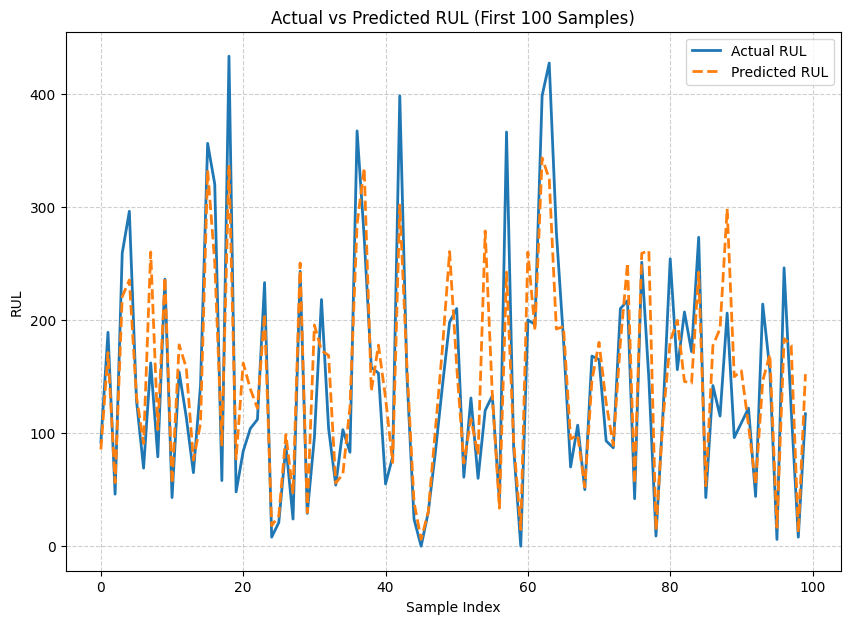

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(y_test.values[:100], label='Actual RUL', linewidth=2)
plt.plot(y_pred_xgb[:100], label='Predicted RUL', linewidth=2, linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL (First 100 Samples)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


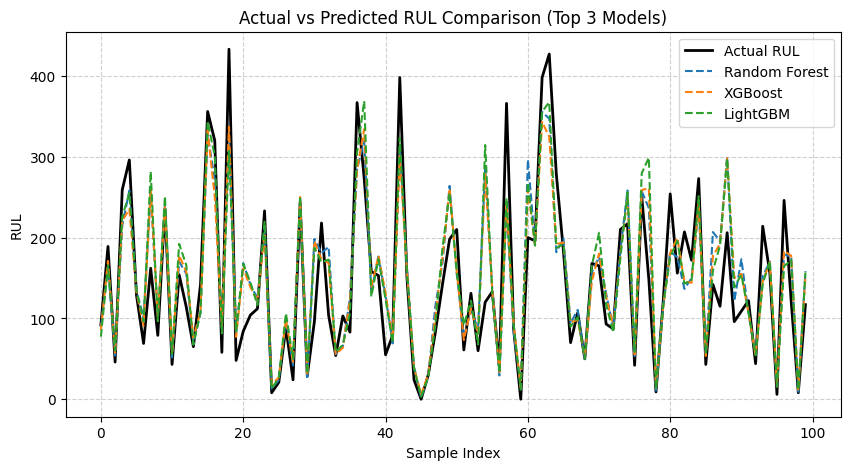

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual RUL', color='black', linewidth=2)
plt.plot(y_pred_rf[:100], label='Random Forest', linestyle='--')
plt.plot(y_pred_xgb[:100], label='XGBoost', linestyle='--')
plt.plot(y_pred_lgb[:100], label='LightGBM', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL Comparison (Top 3 Models)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
